In [152]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import minimize
plt.style.use('../notebooks/style.mpl')

In [153]:
import warnings
warnings.filterwarnings('ignore')

# Respiratory heterotrophy model

In [154]:
eps = 1e-10
tau = 1e-1
S2 = 2.

In [155]:
def growth_rate_obj(phi_values):
    phi_cat, phi_resp, phi_ana, phi_h = phi_values

    # Objective function for optimization
    # Maximizing nu_ana is equivalent to minimizing -nu_ana
    obj = -phi_ana * gamma_ana_inv

    return obj

### Parameters

In [270]:
# gamma inverses are in /hr units.
gamma_cat_inv = 0.5
gamma_resp_inv = 2.0
gamma_ana_inv = 0.5
gamma_hom_inv = 0.5

phi_cat = 0.3
phi_ana = 0.2
phi_resp = 0.1
phi_h = 0.1
phi_o = 1 - (phi_cat + phi_ana + phi_resp + phi_h)

# maintenance energy
maint = 0.01

# Default params: reliance on respiration.
S4 = 1.0    # ATP yield of respiration
S3 = 0.5    # ATP yield of catabolism
S5 = 0.3    # ATP cost of anabolism
S6 = 0.1    # reduction coefficient of biomass

### Initial conditions

In [271]:
# concentrations in KM units
Corg0 = 1e2
NADH0 = 1e-1
O20 = 1e1
ATP0 = 1e-1

# KM is in uM
KM = 100
r1 = 10.
r2 = 0.1

In [272]:
NADH = NADH0
ATP = ATP0

In [273]:
S6 = 0.5

In [274]:
# Set the value of phi_o
phi_o = 0.2
maint = 0.00

# Initial guess for the phi variables
phi_values0 = [0.1, 0.1, 0.1, 0.1]  # update as necessary

# Bounds for the phi variables (assuming they are between 0 and 1)
bounds = [(0.00, 1), (0.00, 1), (0.00, 1), (0.00, 1)]  # update as necessary

# Constraint function for the sum of phi parameters
cons = ({'type': 'eq', 'fun': lambda x:  sum(x) - (1 - phi_o)},
        {'type': 'eq', 'fun': lambda x:  S2 * x[0] * gamma_cat_inv * tau - 2 * x[1] * gamma_resp_inv * tau - S6 * x[2] * gamma_ana_inv * tau - x[2] * gamma_ana_inv * tau * NADH},
        {'type': 'eq', 'fun': lambda x:  S3 * x[0] * gamma_cat_inv * tau + S4 * x[1] * gamma_resp_inv * tau - S5 * x[2] * gamma_ana_inv * tau - x[3] * gamma_hom_inv * tau - maint - x[2] * gamma_ana_inv * tau * ATP})

# Call the optimizer
res = minimize(growth_rate_obj, phi_values0, method='SLSQP', bounds=bounds, constraints=cons)

# Extract the optimal phi values
phi_cat_opt, phi_resp_opt, phi_ana_opt, phi_h_opt = res.x

print('Chosen phi_o:', phi_o)
print('Optimal phi_cat:', phi_cat_opt)
print('Optimal phi_resp:', phi_resp_opt)
print('Optimal phi_ana:', phi_ana_opt)
print('Optimal phi_h:', phi_h_opt)


Chosen phi_o: 0.2
Optimal phi_cat: 0.2475138121570852
Optimal phi_resp: 0.022099447514081907
Optimal phi_ana: 0.530386740328833
Optimal phi_h: 0.0


Checking if all constraints are satisfied

In [275]:
print('Allocation constraint satisfied:', np.isclose(cons[0]['fun'](res.x), 0, atol=1e-6))
print('NADH balanced:', np.isclose(cons[1]['fun'](res.x), 0, atol=1e-6))
print('ATP balanced:', np.isclose(cons[2]['fun'](res.x), 0, atol=1e-6))

Allocation constraint satisfied: True
NADH balanced: True
ATP balanced: True


In [276]:
-res.fun

0.2651933701644165

# Varying $S_6$

In [290]:
# Set the value of phi_o and maintenance
phi_o = 0.2
maint = 0.001

# Lists to store results
opt_phi_cats = []
opt_phi_resps = []
opt_phi_anas = []
opt_phi_hs = []
fun_mins = []
S6_values = np.linspace(-3, 3, 100)

for S6 in S6_values:
    # Fixed concentrations of ATP and NADH.
    NADH = 1e-1
    ATP = 1e-1
    
    # Initial guess for the phi variables
    phi_values0 = [0.1, 0.1, 0.1, 0.1]

    # Bounds for the phi variables
    bounds = [(0.00, 1), (0.00, 1), (0.00, 1), (0.00, 1)]

    # Constraint function for the sum of phi parameters
    cons = ({'type': 'eq', 'fun': lambda x:  sum(x) - (1 - phi_o)},
            {'type': 'eq', 'fun': lambda x:  S2 * x[0] * gamma_cat_inv * tau - 2 * x[1] * gamma_resp_inv * tau - S6 * x[2] * gamma_ana_inv * tau - x[2] * gamma_ana_inv * tau * NADH},
            {'type': 'eq', 'fun': lambda x:  S3 * x[0] * gamma_cat_inv * tau + S4 * x[1] * gamma_resp_inv * tau - S5 * x[2] * gamma_ana_inv * tau - x[3] * gamma_hom_inv * tau - maint - x[2] * gamma_ana_inv * tau * ATP})

    # Call the optimizer
    res = minimize(growth_rate_obj, phi_values0, method='SLSQP', bounds=bounds, constraints=cons)

    # Extract the optimal phi values
    phi_cat_opt, phi_resp_opt, phi_ana_opt, phi_h_opt = res.x
    
    # Saving the optimal values.
    opt_phi_cats.append(phi_cat_opt)
    opt_phi_resps.append(phi_resp_opt)
    opt_phi_anas.append(phi_ana_opt)
    opt_phi_hs.append(phi_h_opt)
    fun_mins.append(-res.fun)

# Combine results into a DataFrame
df = pd.DataFrame({
    's6s': S6_values,
    'opt_phi_cat': opt_phi_cats,
    'opt_phi_resp': opt_phi_resps,
    'opt_phi_ana': opt_phi_anas,
    'opt_phi_h': opt_phi_hs,
    'lambda': fun_mins,
})

In [291]:
df

,s6s,opt_phi_cat,opt_phi_resp,opt_phi_ana,opt_phi_h,lambda
0,-3.000000,2.775558e-17,1.232124e-01,0.339896,0.336891,0.169948
1,-2.939394,8.326673e-17,1.225618e-01,0.345318,0.332120,0.172659
2,-2.878788,1.387779e-16,1.218901e-01,0.350916,0.327194,0.175458
3,-2.818182,5.551115e-17,1.211962e-01,0.356698,0.322106,0.178349
4,-2.757576,0.000000e+00,1.204791e-01,0.362674,0.316847,0.181337
...,...,...,...,...,...,...
95,2.757576,4.270975e-01,0.000000e+00,0.298923,0.073980,0.149461
96,2.818182,4.290465e-01,2.775558e-17,0.294051,0.076903,0.147025
97,2.878788,4.309329e-01,0.000000e+00,0.289334,0.079733,0.144667
98,2.939394,4.327598e-01,8.326673e-17,0.284767,0.082473,0.142384


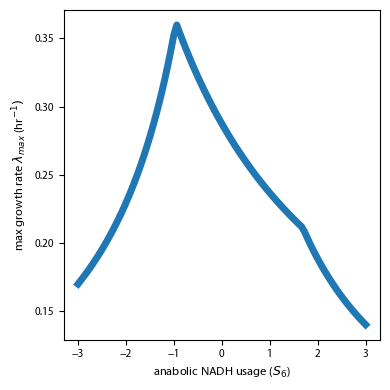

In [292]:
fig, ax = plt.subplots( 1, 1, figsize=(4, 4) )

ax.set_ylabel( 'max growth rate ' + r'$\lambda_{max}$' + ' (hr' + r'$^{-1})$' )
ax.set_xlabel( 'anabolic NADH usage (' + r'$S_6$)')
ax.plot( df['s6s'], df['lambda'], lw=5 )

fig.tight_layout()
plt.show()